# Imports

In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score,confusion_matrix, accuracy_score,f1_score, roc_auc_score,auc, roc_curve, recall_score,log_loss,classification_report, make_scorer
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, GridSearchCV,RepeatedStratifiedKFold,cross_val_score
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve,cross_validate
from mlxtend.evaluate import paired_ttest_5x2cv
from catboost import CatBoostClassifier
#reproducibility
SEED=6


# Importing Data

In [ ]:
data=pd.read_csv("Clean Transformed.csv")


We drop Region Code Column based on phase 2 results

In [ ]:
data=data.drop("Region_Code",axis=1)

In [ ]:
data.head()

,Age,Vehicle_Age_Ordinal,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes,Age_times_Annual,Response
0,44,2.0,40454,26,217,0,1,0,1,1,0,0,1,1779976.0,1
1,47,2.0,38294,26,27,0,1,0,1,1,0,0,1,1799818.0,1
2,21,1.0,28619,152,203,0,1,0,1,0,1,1,0,600999.0,0
3,29,1.0,27496,152,39,1,0,0,1,0,1,1,0,797384.0,0
4,24,1.0,2630,160,176,1,0,0,1,1,0,0,1,63120.0,0


We transformed float type features to integer cause catboost model only supports integers

In [ ]:
#for catboost since it doesnt support float types

data["Vehicle_Age_Ordinal"] = data["Vehicle_Age_Ordinal"].astype(np.int) 
data["Age_times_Annual"]=data["Age_times_Annual"].astype(np.int)

In [ ]:
print("\n\nDatatypes of features: \n",'-' * 20,"\n", data.dtypes)



Datatypes of features: 
 -------------------- 
 Age                     int64
Vehicle_Age_Ordinal     int64
Annual_Premium          int64
Policy_Sales_Channel    int64
Vintage                 int64
Gender_Female           int64
Gender_Male             int64
Driving_License_0       int64
Driving_License_1       int64
Previously_Insured_0    int64
Previously_Insured_1    int64
Vehicle_Damage_No       int64
Vehicle_Damage_Yes      int64
Age_times_Annual        int64
Response                int64
dtype: object


Spliting the Data into 20% test and 20% train

In [ ]:
label=data['Response']

features=data.drop(['Response'], axis = 1)

X_train,X_test,Y_train,Y_test = train_test_split(features,label,test_size= 0.20,random_state=SEED,shuffle=True)

In [ ]:
X_train

,Age,Vehicle_Age_Ordinal,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes,Age_times_Annual
155259,26,1,32254,152,70,1,0,0,1,0,1,1,0,838604
386621,27,1,25862,151,289,1,0,0,1,1,0,0,1,698274
136666,47,0,53903,122,187,1,0,0,1,1,0,0,1,2533441
357901,43,2,60877,124,161,0,1,0,1,1,0,0,1,2617711
365964,48,0,30989,26,20,0,1,0,1,1,0,0,1,1487472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266858,24,1,59353,152,237,0,1,0,1,1,0,0,1,1424472
239572,55,0,2630,9,268,0,1,0,1,0,1,1,0,144650
303331,44,0,38462,124,76,0,1,0,1,0,1,1,0,1692328
379593,30,1,38750,152,151,1,0,0,1,1,0,1,0,1162500


# SMOTE

SMOTE stands for Synthetic Minority Oversampling Technique. This is a statistical technique
for increasing the number of cases in your dataset in a balanced way. The module works by
generating new instances from existing minority cases that you supply as input.

SMOTE gives the same results given the same data, so by applying SMOTE here we get the same data that we trained on in phase 3, which makes our hypothesis testing valid

In [ ]:
# transform the dataset
X_train_oversampled, Y_train = SMOTE().fit_resample(X_train, Y_train)
X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


This cell is to make sure that the newly created dataset has an equal number of positive and negative occurrences is equal to avoid high bias for a certain class

In [ ]:
from collections import Counter
counter = Counter(Y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.000


This shows that the number of positive and negative responses (result class ) are equal.

# SHAP (Part 3)


In [ ]:
import shap
explainer = shap.TreeExplainer(XGB)
expected_value=explainer.expected_value
shap_values = explainer.shap_values(X_train)

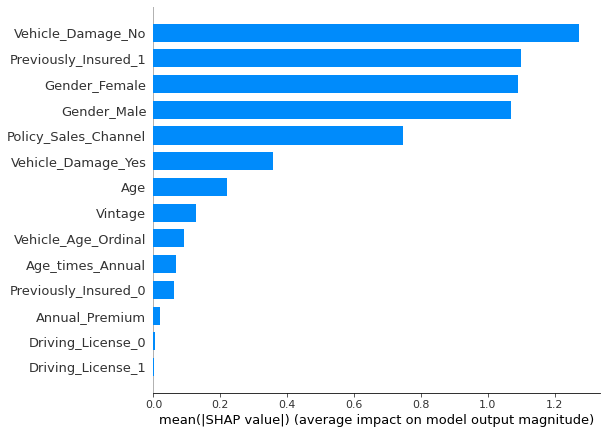

In [102]:

shap.summary_plot(shap_values, X_train,plot_type="bar")


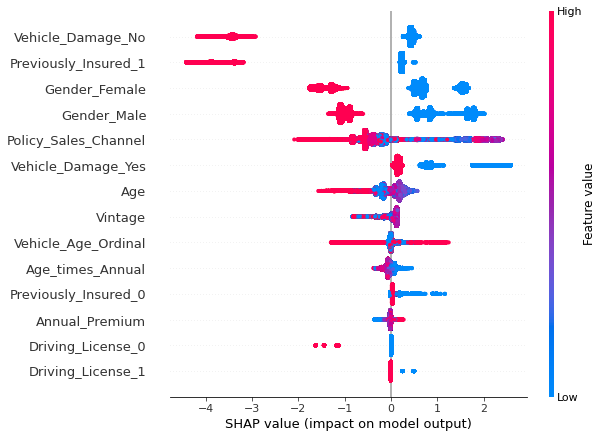

In [113]:
#different way to visualise it
shap.summary_plot(shap_values, X_train)

As we see from the bar plot, having an intact car is affecting the decision of the customers for a car insurance which makes sense since people would like to keep their car undamaged. Having a previous health insurance is also affecting the health insurance response in a positive way, which might reflect that most people also care about their cars as much as their health. 

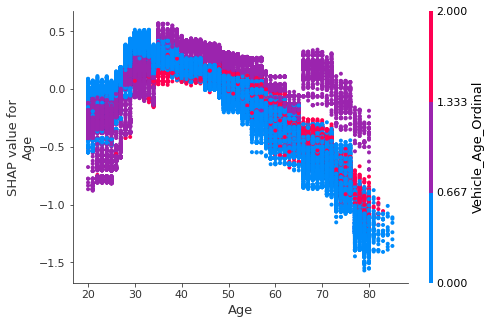

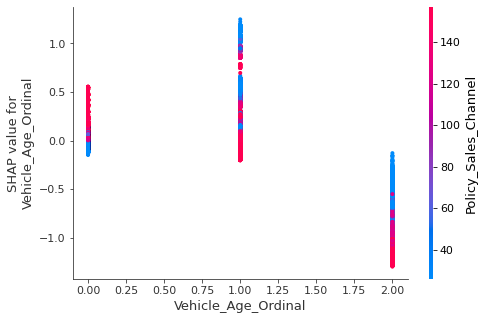

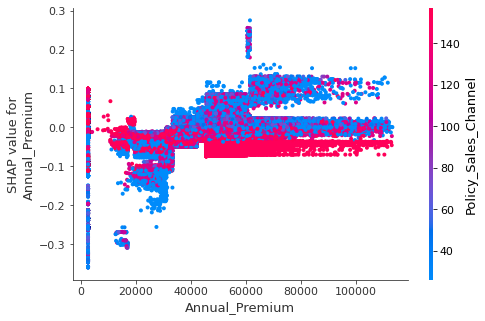

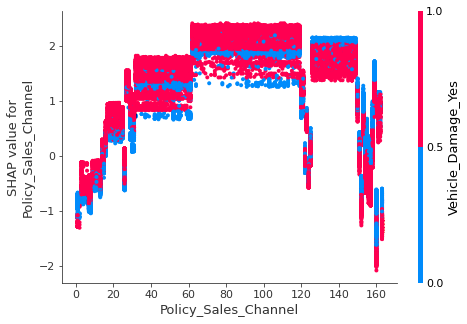

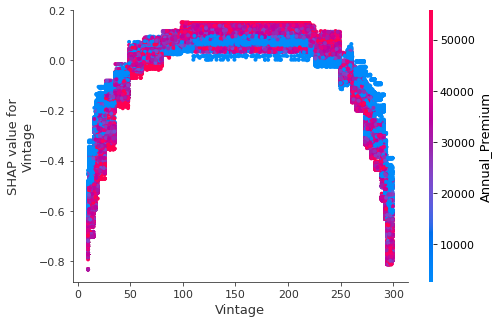

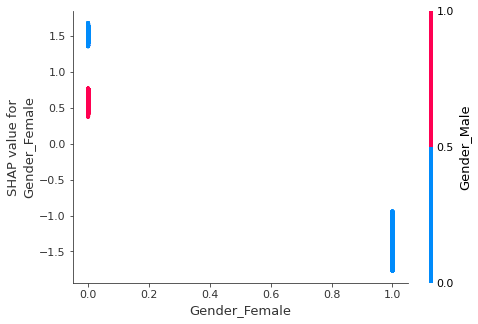

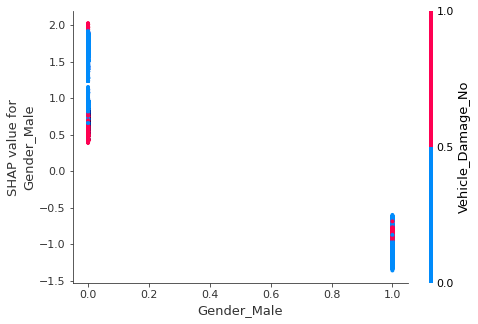

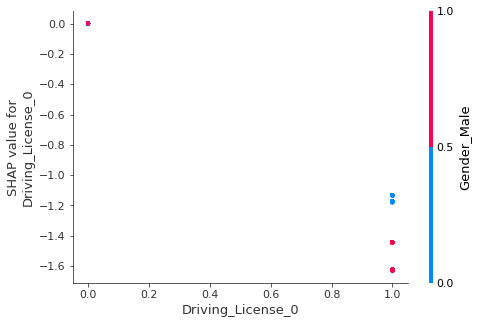

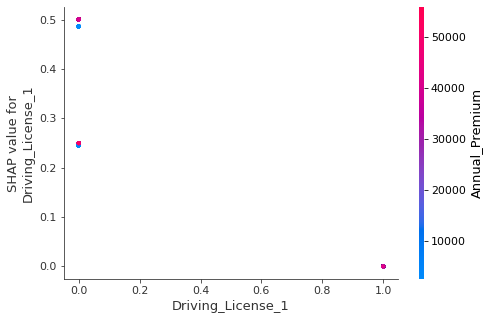

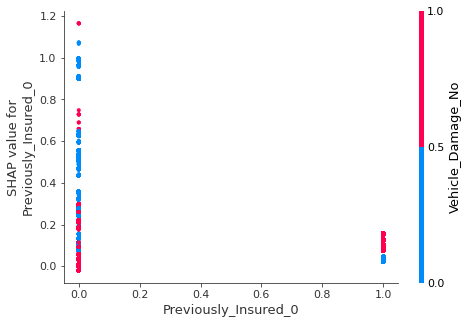

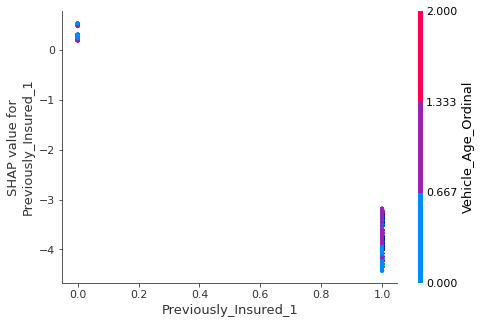

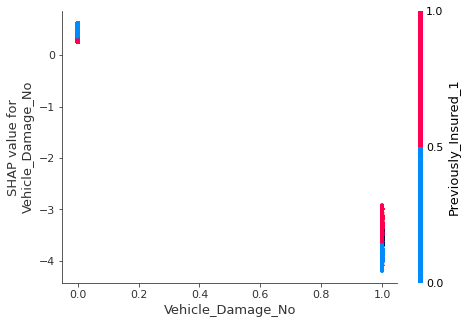

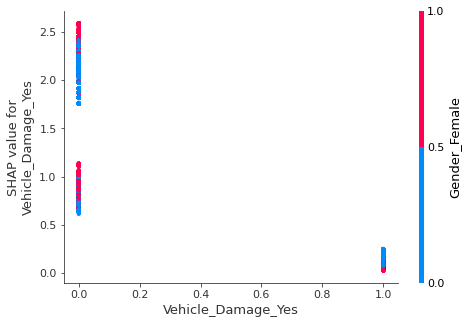

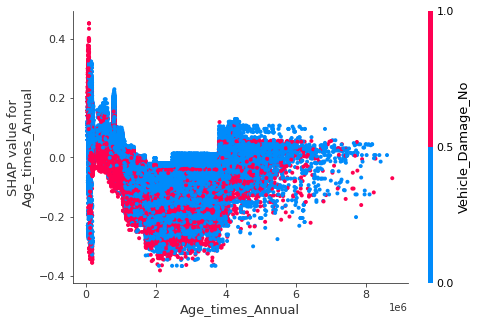

In [116]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)



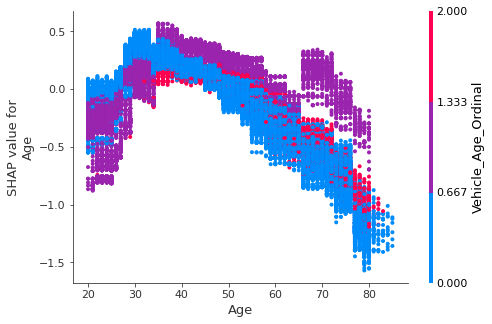

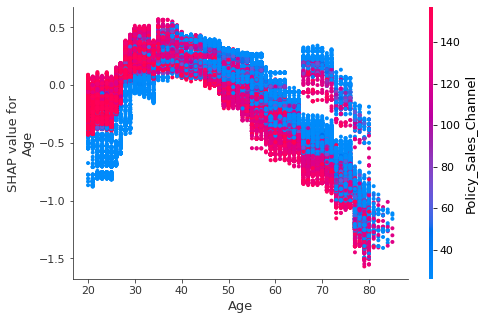

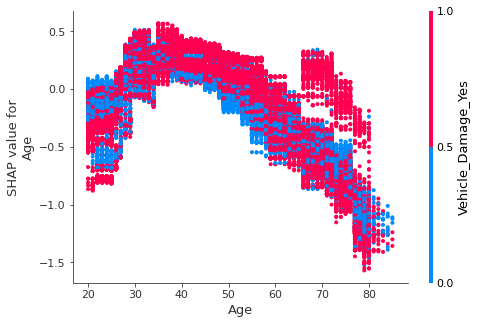

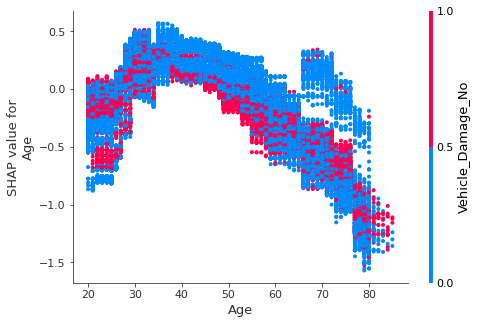

In [122]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("Age", shap_values, X_train)

# make plots colored by each of the top four possible interacting features
for i in range(4):
    shap.dependence_plot("Age", shap_values, X_train, interaction_index=inds[i])


We can see that more damaged vehicles appear after age of 40. As this data has been oversampled, I am not sure how accurate this feature interaction plotting is, but the mentioned interaction which might reflect that people above 40 have had their cars for longer time hence might have had more accidents. From first graph, we see that vehicles with age >2 years are more frequent with people above 35 years old and this supports my claim.

In [156]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

The male customers who have intact cars are affecting the output in positive way as mentioned before. Having damaged cars is negatively affecting it since the car is already damaged and the car insurance might not be needed anymore.